In [7]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [8]:
class Transforms():
    def __init__(self):
        pass

    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 112
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 112
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        ###
        landmarks = landmarks / torch.tensor([np.array(image).shape[0]/224, np.array(image).shape[0]/224])
        ###
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])
        
        if(width > height) :
            left = left - width*0.25
            top = top + height*0.5 - width*0.5 - width*0.25
            width = width*1.5
            height = width
        else :
            top = top - height*0.25
            left = left + width*0.5 - height*0.5 - height*0.25
            height = height*1.5
            width = height

        image = TF.crop(image, top, left, height, width)
        
        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        #landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)

        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        
        return image, landmarks

class Transforms_Flip():
    def __init__(self):
        pass

    def flip(self, image, landmarks):
        image = cv2.flip(np.array(image), 1)
        landmarks[:, 0] = image.shape[1] - landmarks[:, 0]
        return Image.fromarray(image), landmarks
    
    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 112
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 112
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        ###
        landmarks = landmarks / torch.tensor([np.array(image).shape[0]/224, np.array(image).shape[0]/224])
        ###
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])
        
        if(width > height) :
            left = left - width*0.25
            top = top + height*0.5 - width*0.5 - width*0.25
            width = width*1.5
            height = width
        else :
            top = top - height*0.25
            left = left + width*0.5 - height*0.5 - height*0.25
            height = height*1.5
            width = height

        image = TF.crop(image, top, left, height, width)
        
        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        #landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)
        image, landmarks = self.flip(image, landmarks)
            
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        
        return image, landmarks

In [9]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):
        tree = ET.parse('./300W/labels_300W_new_1.xml')
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir= './300W'
        
        
        index_k = 0
        for filename in root[0]:
            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            
            y_l = landmark[37][1], landmark[41][1], landmark[38][1], landmark[40][1]  # left eye
            y_r = landmark[43][1], landmark[47][1], landmark[44][1], landmark[46][1]  # right eye
            y_n = landmark[33][1], landmark[51][1] # nose tip to top of mouth
            avg = 0
            for j in range(2) :
                avg = avg - y_l[2*j] + y_l[2*j+1] - y_r[2*j] + y_r[2*j+1]
            avg = avg/4
            nom = (-y_n[0]+y_n[1])
            if nom == 0 :
                nom = 1
            val = avg/nom
            
            if val> 0.2:
                index_k += 1
                self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))
                self.crops.append(filename[0].attrib)
                self.landmarks.append(landmark)                
            elif val <= 0.2:
                for i in range(28) :
                    self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))
                    self.crops.append(filename[0].attrib)
                    self.landmarks.append(landmark)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]
        
        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        #landmarks = landmarks - 0.5

        return image, landmarks
    
dataset = FaceLandmarksDataset(Transforms())
#dataset_flip = FaceLandmarksDataset(Transforms_Flip())
#dataset = dataset + dataset_flip

In [10]:
print(len(dataset))
idx = int(len(dataset)/2)
print(dataset[0][1][0])
print(dataset[idx][1][0])

8398
tensor([ 53.0079, 103.9064])
tensor([59.4095, 78.1803])


In [5]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=2, shuffle=True, num_workers=0)

The length of Train set is 7559
The length of Valid set is 839


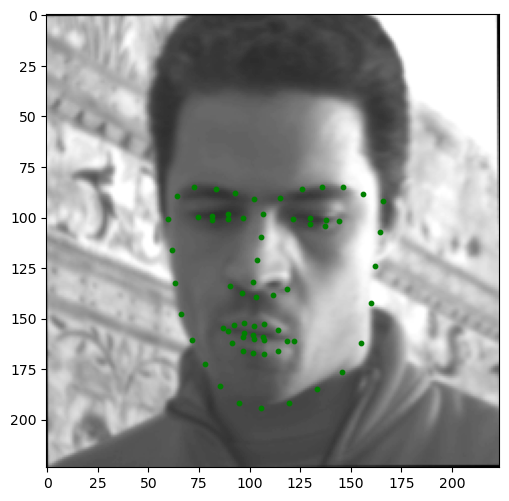

In [6]:
images, landmarks = next(iter(train_loader))
plt.figure(figsize=(600/100, 600/100), dpi=100)
plt.scatter(landmarks[0,:,0], landmarks[0,:,1], c = 'g', s = 10)
plt.imshow(images[0].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')

In [11]:
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet34'
        self.model=models.resnet34(pretrained=False)
        #self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=2, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [12]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

In [13]:
torch.autograd.set_detect_anomaly(True)
network = Network()
network.cuda()
#network.load_state_dict(torch.load('./Vacancy_9.pth'))
#network.eval()

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 200

start_time = time.time()
train_losses = []
valid_losses = []
for epoch in range(1,num_epochs+1):
    epoch_time = time.time()
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(train_loader)+1):
    
        images, landmarks = next(iter(train_loader))
        
        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
        predictions = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
        
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    train_losses.insert(epoch, loss_train)
    valid_losses.insert(epoch, loss_valid)
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), 'Vacancy_16.pth') # 1 : dataset : 300W & openCVDNN, network : resnet34(3,1,2), preprocess : 50% of openCVDNN
                                                          # 2 : dataset 3219->3816(multi-face images not ommitted)
                                                          # 3 : dataset split (open only)
                                                          # 7 : oversampling & downsampling (0.5 : 19)
                                                          # 8 : oversampling & downsampling (0.25 : 9)
                                                          # 9 : oversampling (1:39)
                                                          # 10 : oversampling (1:39) WITH 200 EPOCHS
                                                          # 11 : oversampling (1:39) with smaller kernel
                                                          # 12 : data : 300w, flips added, pretraiend on (10+ : overfitting)
                                                          # 13 : data : 300w, flips added, pretraiend off
                                                          # 15 : network : coarsed
                                                          # 16 : w/o flips. 300w added only from 11

        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
        print("Total Elapsed Time : {} s".format(time.time()-epoch_time))
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

import csv
with open('Vacancy_16_epochs.csv', 'w', newline='') as f: 
    writer = csv.writer(f) 
    writer.writerow(train_losses) 
    writer.writerow(valid_losses) 

Valid Steps: 420/420  Loss: 60.2606  
--------------------------------------------------
Epoch: 1  Train Loss: 90.7380  Valid Loss: 60.2606
--------------------------------------------------

Minimum Validation Loss of 60.2606 at epoch 1/200
Model Saved

Total Elapsed Time : 405.75097489356995 s
Valid Steps: 420/420  Loss: 12.9160 
--------------------------------------------------
Epoch: 2  Train Loss: 32.8483  Valid Loss: 12.9160
--------------------------------------------------

Minimum Validation Loss of 12.9160 at epoch 2/200
Model Saved

Total Elapsed Time : 377.7665145397186 s
Valid Steps: 420/420  Loss: 8.4796  
--------------------------------------------------
Epoch: 3  Train Loss: 9.7283  Valid Loss: 8.4796
--------------------------------------------------

Minimum Validation Loss of 8.4796 at epoch 3/200
Model Saved

Total Elapsed Time : 375.0928621292114 s
Valid Steps: 420/420  Loss: 8.3999 
--------------------------------------------------
Epoch: 4  Train Loss: 8.5911 

Valid Steps: 420/420  Loss: 2.0149 
--------------------------------------------------
Epoch: 34  Train Loss: 1.9747  Valid Loss: 2.0149
--------------------------------------------------
Valid Steps: 420/420  Loss: 1.8288 
--------------------------------------------------
Epoch: 35  Train Loss: 1.9597  Valid Loss: 1.8288
--------------------------------------------------

Minimum Validation Loss of 1.8288 at epoch 35/200
Model Saved

Total Elapsed Time : 366.35577154159546 s
Valid Steps: 420/420  Loss: 1.8265 
--------------------------------------------------
Epoch: 36  Train Loss: 1.8998  Valid Loss: 1.8265
--------------------------------------------------

Minimum Validation Loss of 1.8265 at epoch 36/200
Model Saved

Total Elapsed Time : 364.28806710243225 s
Valid Steps: 420/420  Loss: 2.0721 
--------------------------------------------------
Epoch: 37  Train Loss: 1.9013  Valid Loss: 2.0721
--------------------------------------------------
Valid Steps: 420/420  Loss: 1.7701 


Valid Steps: 420/420  Loss: 1.3120 
--------------------------------------------------
Epoch: 71  Train Loss: 1.1851  Valid Loss: 1.3120
--------------------------------------------------
Valid Steps: 420/420  Loss: 1.3952 
--------------------------------------------------
Epoch: 72  Train Loss: 1.1672  Valid Loss: 1.3952
--------------------------------------------------
Valid Steps: 420/420  Loss: 1.4844 
--------------------------------------------------
Epoch: 73  Train Loss: 1.1598  Valid Loss: 1.4844
--------------------------------------------------
Valid Steps: 420/420  Loss: 1.4129 
--------------------------------------------------
Epoch: 74  Train Loss: 1.1091  Valid Loss: 1.4129
--------------------------------------------------
Valid Steps: 420/420  Loss: 1.3227 
--------------------------------------------------
Epoch: 75  Train Loss: 1.1150  Valid Loss: 1.3227
--------------------------------------------------
Valid Steps: 420/420  Loss: 1.4274 
------------------------

Valid Steps: 420/420  Loss: 1.0599 
--------------------------------------------------
Epoch: 113  Train Loss: 0.7773  Valid Loss: 1.0599
--------------------------------------------------

Minimum Validation Loss of 1.0599 at epoch 113/200
Model Saved

Total Elapsed Time : 381.1539282798767 s
Valid Steps: 420/420  Loss: 1.1643 
--------------------------------------------------
Epoch: 114  Train Loss: 0.7619  Valid Loss: 1.1643
--------------------------------------------------
Valid Steps: 420/420  Loss: 1.1296 
--------------------------------------------------
Epoch: 115  Train Loss: 0.7578  Valid Loss: 1.1296
--------------------------------------------------
Valid Steps: 420/420  Loss: 1.0852 
--------------------------------------------------
Epoch: 116  Train Loss: 0.7677  Valid Loss: 1.0852
--------------------------------------------------
Valid Steps: 420/420  Loss: 1.0672 
--------------------------------------------------
Epoch: 117  Train Loss: 0.7584  Valid Loss: 1.0672


Valid Steps: 420/420  Loss: 0.9931 
--------------------------------------------------
Epoch: 152  Train Loss: 0.5917  Valid Loss: 0.9931
--------------------------------------------------
Valid Steps: 420/420  Loss: 0.9537 
--------------------------------------------------
Epoch: 153  Train Loss: 0.5868  Valid Loss: 0.9537
--------------------------------------------------
Valid Steps: 420/420  Loss: 0.9087 
--------------------------------------------------
Epoch: 154  Train Loss: 0.5929  Valid Loss: 0.9087
--------------------------------------------------

Minimum Validation Loss of 0.9087 at epoch 154/200
Model Saved

Total Elapsed Time : 383.1035826206207 s
Valid Steps: 420/420  Loss: 0.9677 
--------------------------------------------------
Epoch: 155  Train Loss: 0.5701  Valid Loss: 0.9677
--------------------------------------------------
Valid Steps: 420/420  Loss: 0.9892 
--------------------------------------------------
Epoch: 156  Train Loss: 0.5739  Valid Loss: 0.9892


Valid Steps: 420/420  Loss: 0.9362 
--------------------------------------------------
Epoch: 193  Train Loss: 0.4535  Valid Loss: 0.9362
--------------------------------------------------
Valid Steps: 420/420  Loss: 0.9806 
--------------------------------------------------
Epoch: 194  Train Loss: 0.4686  Valid Loss: 0.9806
--------------------------------------------------
Valid Steps: 420/420  Loss: 1.0044 
--------------------------------------------------
Epoch: 195  Train Loss: 0.4629  Valid Loss: 1.0044
--------------------------------------------------
Valid Steps: 420/420  Loss: 0.8989 
--------------------------------------------------
Epoch: 196  Train Loss: 0.4555  Valid Loss: 0.8989
--------------------------------------------------
Valid Steps: 420/420  Loss: 0.8803 
--------------------------------------------------
Epoch: 197  Train Loss: 0.4622  Valid Loss: 0.8803
--------------------------------------------------
Valid Steps: 420/420  Loss: 0.9260 
-------------------